# Investigating NICS Firearm Background Checks with FBI Gun Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#datacleaning">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#sourceindex">Source Index</a></li>
</ul>

<a id='intro'></a>
## Introduction

This data comes from the <a href="https://www.fbi.gov/services/cjis/nics">FBI's National Instant Criminal Background Check System</a>. From the official site:

> Mandated by the Brady Handgun Violence Prevention Act of 1993 and launched by the FBI on November 30, 1998, NICS is used by Federal Firearms Licensees (FFLs) to instantly determine whether a prospective buyer is eligible to buy firearms. Before ringing up the sale, cashiers call in a check to the FBI or to other designated agencies to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. More than 230 million such checks have been made, leading to more than 1.3 million denials.

Before moving onto the meat of this investigation, I want to bring up a few notes.

#### Firearm Background Checks Do Not Equal Sales

At the beginning of this project, I wanted to use the data to calculate gun sales. It turns out that calculating this statistic is more complex than you would think.

In the <a href='https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/vieworiginal'>PDF files</a> the FBI provides, there is an important note:

>These statistics represent the number of firearm background checks initiated through the NICS They do not represent the number of firearms sold Based on varying state laws and purchase scenarios, a one-to-one correlation cannot be made between a firearm background check and a firearm sale

Even though a one-to-one correlation cannot be made between a check and a sale, some organizations have estimated gun sales with this data. For example, the <a href='https://www.nytimes.com/interactive/2015/12/10/us/gun-sales-terrorism-obama-restrictions.html'>New York Times</a> used a method suggested in the <a href='http://www.smallarmssurvey.org/fileadmin/docs/F-Working-papers/SAS-WP14-US-Firearms-Industry.pdf'>Small Arms Survey</a> by Jurgen Brauer, a professor at Georgia Regents University. Long gun and handgun checks were counted as 1.1 sales, and multiple-gun checks were counted as two sales. Permit and other types of checks were omitted. The mulitplier used in the survey were based on interviews Mr. Brauer had with gun shop owners.

So background checks do not equal sales, but you can have a grasp of what gun sales are by visualizing this data.

#### States cannot be directly compared

In the visualization section, you will see statistics by state in some of the graphs. When looking at these, keep in mind that even though you can estimate gun sales using the NICS background check data, state laws for firearms differ from each other all across the nation. Even knowing this, the statistics between each state were still very interesting to learn about.

<a id='wrangling'></a>
# Data Wrangling

### The Gun Data

The data used to explore the firearm background checks can be downloaded from a <a href='https://github.com/BuzzFeedNews/nics-firearm-background-checks'>BuzzFeed News GitHub repository here</a>.

>The code in this GitHub repository downloads that PDF, parses it, and produces a spreadsheet/CSV of the data. <a href='https://raw.githubusercontent.com/BuzzFeedNews/nics-firearm-background-checks/master/data/nics-firearm-background-checks.csv'>Click here to download the data</a>, which currently covers November 1998 – February 2018.

### The Census Data

The population numbers come from the the United States Census government website <a href='https://www.census.gov/data/tables/2017/demo/popest/nation-total.html#ds'>here</a>. This data has annual estimates of the resident population for the U.S. from April 1, 2010 to July 1, 2017.

While exploring this data, I realized that I needed numbers for <a href='https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_B09001&prodType=table'>children under 18 within each state</a>. As you'll see in the visualization, this was used to calculate how many people were of age to recieve a background check while buying a gun. That number was then used to calculate the percentage of checks compared to the population of that state.

Let's explore.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [26]:
df_c17 = pd.read_csv('nst-est2017-01.csv')
df_gun = pd.read_csv('nics-firearm-background-checks.csv')

In [27]:
df_gun.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2018-02,Alabama,24547.0,0.0,9220.0,7172.0,353.0,490,0.0,15.0,...,0.0,0.0,0.0,29.0,39.0,4.0,0.0,1.0,2.0,45171
1,2018-02,Alaska,214.0,0.0,2279.0,1948.0,268.0,166,0.0,2.0,...,0.0,0.0,0.0,17.0,5.0,6.0,0.0,0.0,0.0,5392
2,2018-02,Arizona,6513.0,435.0,14966.0,9058.0,1341.0,934,0.0,15.0,...,0.0,0.0,0.0,20.0,18.0,5.0,0.0,2.0,0.0,36281
3,2018-02,Arkansas,4341.0,970.0,7671.0,6405.0,338.0,614,48.0,18.0,...,0.0,0.0,0.0,24.0,33.0,3.0,0.0,0.0,0.0,24266
4,2018-02,California,39165.0,0.0,38531.0,24768.0,3940.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107649


In [28]:
df_gun.shape

(12760, 27)

In [29]:
df_gun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12760 entries, 0 to 12759
Data columns (total 27 columns):
month                        12760 non-null object
state                        12760 non-null object
permit                       12736 non-null float64
permit_recheck               1375 non-null float64
handgun                      12740 non-null float64
long_gun                     12741 non-null float64
other                        5775 non-null float64
multiple                     12760 non-null int64
admin                        12737 non-null float64
prepawn_handgun              10817 non-null float64
prepawn_long_gun             10815 non-null float64
prepawn_other                5390 non-null float64
redemption_handgun           10820 non-null float64
redemption_long_gun          10819 non-null float64
redemption_other             5390 non-null float64
returned_handgun             2475 non-null float64
returned_long_gun            2420 non-null float64
returned_other   




#### Luckily, this dataset is pretty clean. All numbers are floats, so we can quickly get some statistics


In [30]:
df_gun.describe()

,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
count,12736.000000,1375.000000,12740.000000,12741.000000,5775.000000,12760.000000,12737.000000,10817.000000,10815.000000,5390.000000,...,2090.000000,1265.000000,1100.000000,3025.000000,3025.000000,3025.000000,2750.000000,3025.000000,2530.000000,12760.000000
mean,6610.938128,1326.202182,6059.709262,7845.176281,378.960866,271.361834,58.141949,4.871499,7.787887,0.188868,...,1.085167,0.107510,0.107273,17.233058,13.771570,1.231736,0.432727,0.481983,0.108696,22012.392085
std,24700.643313,10282.508342,8796.577531,9311.128953,1337.569194,779.820198,599.162551,10.927737,16.320863,1.082060,...,4.454055,0.835988,0.747055,78.628717,60.243891,4.908641,1.481185,1.582317,0.425143,33629.425268
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,888.000000,2092.000000,18.000000,15.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4686.750000
50%,553.000000,0.000000,3114.000000,5147.000000,129.000000,126.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12519.500000
75%,4421.250000,1.000000,7421.500000,10435.000000,370.500000,303.250000,0.000000,5.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,25846.500000
max,522188.000000,124056.000000,107224.000000,108058.000000,77929.000000,38907.000000,28083.000000,164.000000,269.000000,49.000000,...,64.000000,12.000000,12.000000,1017.000000,777.000000,71.000000,28.000000,17.000000,4.000000,541978.000000


#### Already we can see that the average number of checks between 1998-2018 is 22,012. The most checks that were done in a month was over half a million.

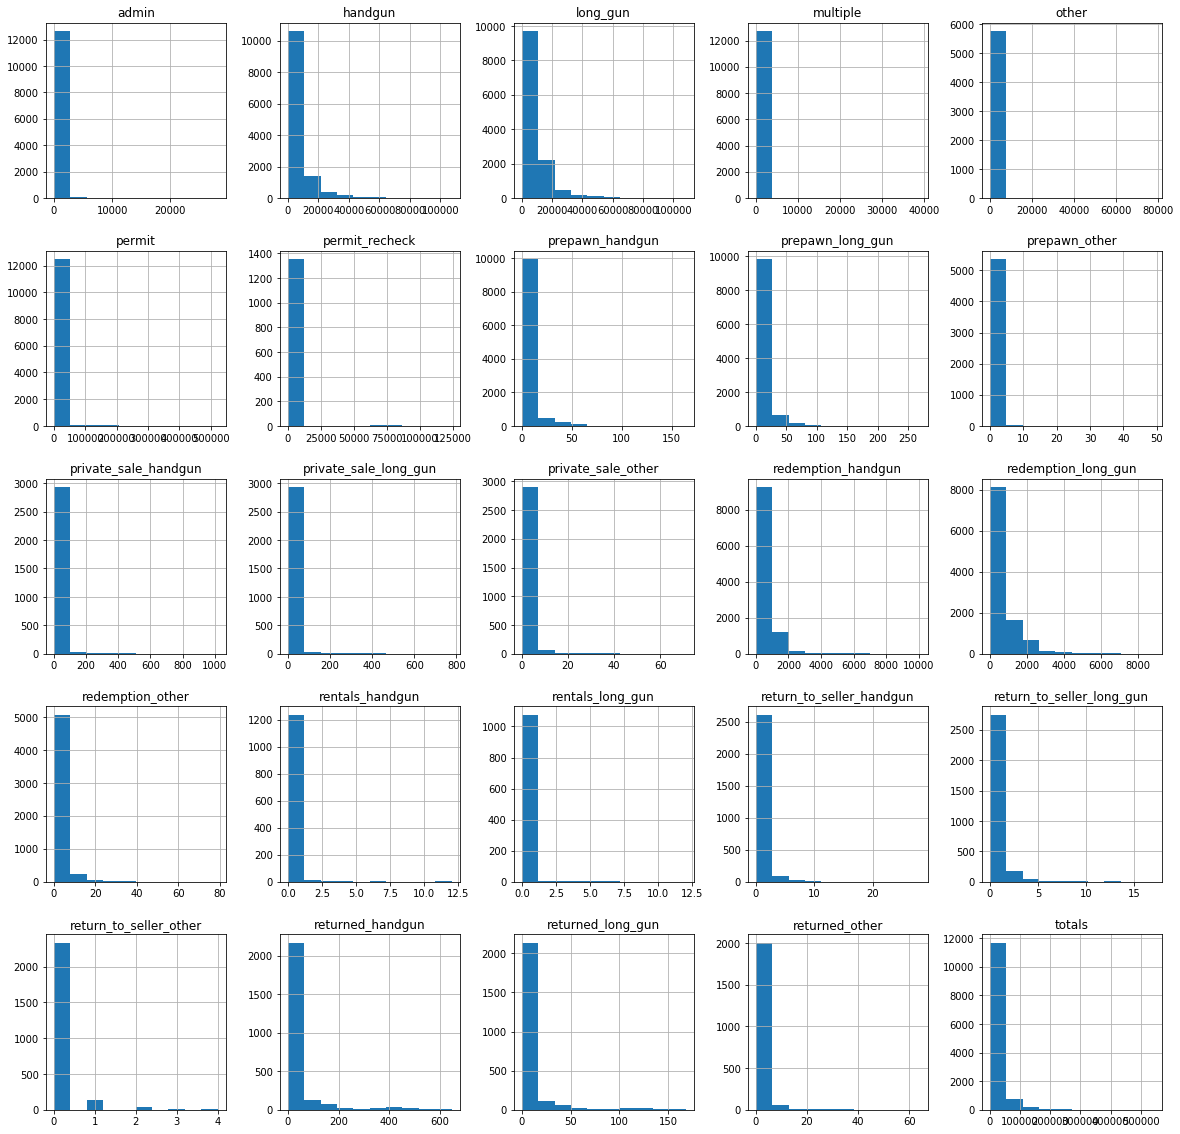

In [ ]:
df_gun.hist(figsize=(20,20));

In [ ]:
pd.plotting.scatter_matrix(df_gun, figsize=(30,30));

#### This scatter plot shows mostly positive relationships with permits and totals as well as the private sale categories. From this information we can expect the number of checks to rise throughout the years in this dataset.

In [ ]:
# lets look at the census data now
df_c17.head()

In [ ]:
df_c17.info()

#### The census data set is quite messy. We need to decide what we actually want to use for this investigation, clean up the column names, and change all of the strings into some integers we can work with. For this project, we will only need the population numbers from 2010-2017 from each region and state.

<a id='datacleaning'></a>
# Data Cleaning

To start the cleaning process, we'll start by narrowing down the rows and columns we need from the census data

In [ ]:
df_c17.head()

#### Since this file was converted to a csv format, the columns and rows are a mess. We'll only need the rows starting at United States

In [ ]:
# only take rows 3 through 59, these include the regions and states we need
df_c17 = df_c17.iloc[3:59]

#rename the columns
df_c17.columns = ['region/state', 'census_april_2010', 'est_base', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

df_c17.head()

#### As we saw in the wrangling process, every single number in this data set are strings, to easily convert them all at once, we can get rid of the region/state column, convert all of the strings to numbers, then bring the column back. We'll do this by first making two copies of the data set.

In [ ]:
#copy the data sets
df1 = df_c17.copy()
df2 = df_c17.copy()

#drop the region/state column from the first copy
df1.drop(columns = ['region/state'], inplace = True)

#get rid of the commas in all of the numbers
for col in df1.columns:
    df1[col] = df1[col].replace({',':''}, regex=True)
    
#change all of the numbers to integers
df1 = df1.apply(pd.to_numeric)

df1.info()

In [ ]:
# strangley, some of the state names had periods in the beginning of the string
df2['region/state'] = df2['region/state'].map(lambda x: x.lstrip('.'))

# change the region/state column into a list to add into other dataframe
df2 = df2['region/state'].tolist()

df2

In [ ]:
# insert the list as a column onto the first copy that we cleaned
df1.insert(loc=0, column='region/state', value=df2)

df1.head()

In [ ]:
# rename the dataframe
df_census_clean = df1

#### Now to bring in the census data for children under 18. This will allow us to calculate how much of the population is over 18 within each state.

In [ ]:
df_underage = pd.read_csv('pop_under_18.csv')

df_underage.head()

#### Like the other census data, this set was a bit messy. We will only need the state and estimated total columns. After we extract that data, we will join it with the other census data.

In [ ]:
# use the first row for the name of the columns
df_underage = df_underage.rename(columns = df_underage.iloc[0])

#drop the row with the orignal column names
df_underage = df_underage.reindex(df_underage.index.drop(0))

#drop all columns after estimated total column
df_underage.drop(df_underage.columns[4:], axis = 1, inplace = True)

#drop the Id and Id2 columns
cols = [0,1]
df_underage.drop(df_underage.columns[cols], axis=1, inplace=True)

# rename columns
df_underage.columns = ['geography', 'est_total']

df_underage.head(1)

#### Lets take a look at the data types to see if we need to convert anything

In [ ]:
df_underage.info()

In [ ]:
# change the est_total column to integers
df_underage['est_total'] = df_underage['est_total'].astype(int)

#### For the next step, we need to join df_underage with df_census clean. This will be done by creating a python dictionary with the underage dataframe, and then mapping the matching states of the census data with the values of df_underage.

In [ ]:
# create empty dictionary
df_underage_dict = {}

# write a loop that takes the assigns the states as keys, and the totals as values
x = 0
while x < len(df_underage):
    state_name = df_underage['geography'].iloc[x]
    total_num = df_underage['est_total'].iloc[x]
    df_underage_dict[state_name] = total_num
    x = x+1
    
df_underage_dict

In [ ]:
# map dictionary to df_census_clean
df_census_clean['pop_underage_2016'] = df_census_clean['region/state'].map(df_underage_dict)

df_census_clean.head(8)

#### Since we don't need or have regional and national data for children under 18, a NaN is put in place of the row. We should change it to an integer.

In [ ]:
# fill NaN with zeros
df_census_clean['pop_underage_2016'].fillna(0, inplace=True)

#### Later on in the analysis, we will need the amount of background checks that were done in 2016. Once we get that data, we'll add it as a column in the census data.

In [ ]:
# get the total checks by each state and each month
checks_by_state = df_gun.groupby(['state', 'month'])['totals'].sum().reset_index()

# data frame for all checks done in 2016
df_gun_2016 = checks_by_state[checks_by_state.month.str.contains('2016') == True]

# get totals in 2016 in each state
df_gun_2016 = df_gun_2016.groupby('state')['totals'].sum()

# change to dict
df_gun_2016 = df_gun_2016.to_dict()

# map values of checks in 2016 to state names in the census data
df_census_clean['gun_permits_2016'] = df_census_clean['region/state'].map(df_gun_2016)

df_census_clean.head()

In [ ]:
# change NaN to 0
df_census_clean['gun_permits_2016'].fillna(0, inplace=True)

df_census_clean.head(8)

<a id='eda'></a>
# Exploratory Data Analysis

## What is the overall trend of gun purchases?

Using the totals from the NICS data, we can see what the overall trend of gun sales are from 1998 to 2018

In [ ]:
# sum the totals by month
totals = df_gun.groupby("month")["totals"].sum()

# plot graph
tick_placement = pd.np.arange(2, len(totals), 12)
plt.style.use('seaborn')
ax = totals.plot(figsize=(20,8))


ax.set_title("Monthly NICS Background Check Totals Since Nov. 1998", fontsize=24)
ax.set_yticklabels([ "{0:,.0f}".format(y) for y in ax.get_yticks() ], fontsize=12);
plt.setp(ax.get_xticklabels(), rotation=0, fontsize=12)
ax.set_xticks(tick_placement)
ax.set_xticklabels([ totals.index[i].split("-")[0] for i in tick_placement ])
ax.set_xlim(0, len(totals) - 1)
ax.set_xlabel("")

#### This visualization shows an exponential increase in background checks since 1998. Each spike shows that gun sales greatly increase in December of each year. The greatest spike being in 2015 due to Black Friday sales. In a report from <a href='https://www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/'>The Trace</a>, it was found that Black Friday in 2015 broke a record in a single 24-hour period with a total of 185,345 background checks processed, or slightly more than two background checks every second. This excerpt has an important note:

> The FBI’s background check numbers come with caveats: As seen in the late February-early March 2014 bubble, many checks are for concealed carry permits, not actual gun sales. Kentucky runs a new check on each concealed carry license holder each month. And of course, the FBI’s numbers don’t include private gun sales, many of which do not require a background check. A forthcoming study conducted by Harvard researchers <a href='https://www.thetrace.org/2015/10/private-sale-loophole-background-check-harvard-research/'>found that roughly 40 percent</a> of respondents had acquired their most recent firearm without going through a background check. Despite those vagaries, the FBI’s NICS numbers are widely accepted as the best proxy for total gun sales in a given time period.

## How many total checks have there been in each state since 1998?

For this visualization, I grouped all of the states together and summed up the total checks per state since 1998

In [ ]:
# group the states and sum the totals
state_totals = checks_by_state.groupby('state')['totals'].sum()

# plot graph
state_total_tick_placement = pd.np.arange(len(state_totals))
plt.style.use('seaborn')
state_ax = state_totals.plot(kind='bar',figsize=(20,8))

state_ax.set_title("NICS Background Check Totals By State Since Nov. 1998", fontsize=24)
state_ax.set_yticklabels([ "{0:,.0f}".format(y) for y in state_ax.get_yticks() ], fontsize=12);
plt.setp(state_ax.get_xticklabels(), fontsize=12)
state_ax.set_xticks(state_total_tick_placement)
state_ax.set_xticklabels(state_totals.index)
state_ax.set_xlim(0, len(state_totals) - 1)
state_ax.set_xlabel("")

#### As you can see in this graph, Kentucky has the most activity in background checks for guns since 1998. The state is known to have the least restrictive gun control laws compared to other states. In a summary of <a href='https://en.wikipedia.org/wiki/Gun_laws_in_Kentucky'>gun laws in Kentucky</a>, you do not need a state permit to purchase, you do not need to register your firearm, there is no assault weapon law, magazine capacity restriction, and an owner license is not required. Background checks for for private sales are not required as well. The concealed carry laws have also loosened. On March 16, 2011, a change to KRS <a href='http://www.lrc.ky.gov/Statutes/statute.aspx?id=43448'>§ 527.020</a> was signed into law by Governor Steve Beshear allowing guns to be carried without a permit in any factory-installed compartment within the passenger area of a vehicle. Previously, such carry was only allowed in a glove compartment.



#### In a <a href='https://www.thetrace.org/2016/11/nra-gun-record-rating-system-straight-a-students/'>report by The Trace</a>, Kentucky has the nation's highest percentage of legislators who got a least an A-minus grade from the NRA. This rating system gives members of Congress a grade ranging from A to F that reflects their voting record on gun rights.

> There are currently 35 states where more than half of all state legislators have a grade of A- or better, according to an analysis of data provided by <a href='https://votesmart.org/'>Vote Smart</a>, a non-partisan, non-profit research organization. In 14 states, including most of those in the gun belt, that majority exceeds two thirds, reaching or approaching veto-proof. In Kentucky and Oklahoma, the number extends beyond 80 percent.

#### Kentucky has also been the victim of recent gun violence. <a href='https://www.cnn.com/2018/01/23/us/kentucky-high-school-shooting/index.html'>On January 23, 2018</a>, 2 students were killed and 18 were injured as a shooter opened fire at a Marshall County High School. The event has led to the introduction of <a href='http://www.lex18.com/story/37602072/state-lawmakers-introduce-gun-control-legislation'>stricter gun laws</a> for the state.

#### In Texas, the second highest state that has activity of firearm background checks on this graph, just one day before the event in Kentucky, a <a href='https://nypost.com/2018/01/22/15-year-old-girl-wounded-in-shooting-at-texas-high-school/'>15-year old girl</a> was injured at a school shooting.

## How much have firearm background checks grown since 1999?

I chose to start at 1999 because when calculating percentage changes from 1998, the numbers are quite large. This was due to very little background check numbers in November of 1998, when the NICS program was created. Below I will show both percentage changes since 1998 and 1999. The latter year gives a more clear picture of how much the checks have grown.

In [ ]:
# a loop that uses the total checks in each state in November 1998
# and compares it to the total checks in 2018
x=0
change_dict = {}
while x < len(checks_by_state):
    og_num = checks_by_state.iloc[x]['totals']
    new_num = checks_by_state.iloc[x + 231]['totals']
    decrease = new_num - og_num
    perc_change = round(decrease / og_num * 100, 0)
    change_dict[checks_by_state.iloc[x]['state']] = perc_change
    x = x + 232

In [ ]:
# change dictionary to a pandas Series
df_percent_change = pd.Series(change_dict, name = 'percent_change')
df_percent_change.index.name = 'state'
df_percent_change

In [ ]:
# drop rows that have inf values
df_percent_change = df_percent_change.replace([np.inf, -np.inf], np.nan).dropna()

# sort from biggest to smallest
df_percent_change = df_percent_change.sort_values(ascending = False)

# plot graph
percent_total_tick_placement = pd.np.arange(len(df_percent_change))
plt.style.use('seaborn')
percent_ax = df_percent_change.plot(kind='bar',figsize=(20,8))

percent_ax.set_title("Firearm Background Check Growth Rate by State Since Nov. 1998", fontsize=24)
percent_ax.set_yticklabels([ "{0:,.0f}".format(y) for y in percent_ax.get_yticks() ], fontsize=12);
plt.setp(percent_ax.get_xticklabels(), fontsize=12)
percent_ax.set_xticks(percent_total_tick_placement)
percent_ax.set_xticklabels(df_percent_change.index)
percent_ax.set_xlim(0, len(df_percent_change) - 1)
percent_ax.set_ylabel('Percent')
percent_ax.set_xlabel("")

#### As you can see, a growth of over 800,000% seems quite large. I further explored the numbers in November

In [ ]:
# november 1998 totals in Illinois
checks_by_state[checks_by_state['state'] == 'Illinois'].iloc[0]

In [ ]:
# Pennsylvania
checks_by_state[checks_by_state['state'] == 'Pennsylvania'].iloc[0]

In [ ]:
# South Carolina
checks_by_state[checks_by_state['state'] == 'South Carolina'].iloc[0]

In [ ]:
# Virginia
checks_by_state[checks_by_state['state'] == 'Virginia'].iloc[0]

In [ ]:
# totals in november 1998 for every state
df_nov98_totals = checks_by_state[checks_by_state.month.str.contains('1998-11') == True]

df_nov98_totals['totals'].mean()

#### After seeing how low the numbers were in November, I decided to check the amount of growth since December of 1999 for each state

In [ ]:
# dataset that excludes November 1998
checks_by_state_clean = checks_by_state[checks_by_state.month.str.contains('1998-11') == False]

# using same method as above to make a dictionary 
# and turn it into a pandas Series
x=0
change_dict_clean = {}
while x < len(checks_by_state_clean):
    og_num = checks_by_state_clean.iloc[x]['totals']
    new_num = checks_by_state_clean.iloc[x + 230]['totals']
    decrease = new_num - og_num
    perc_change = round(decrease / og_num * 100, 0)
    change_dict_clean[checks_by_state_clean.iloc[x]['state']] = perc_change
    x = x + 231

In [ ]:
df_percent_change_clean = pd.Series(change_dict_clean, name = 'percent_change')
df_percent_change_clean.index.name = 'state'
df_percent_change_clean

In [ ]:
# drop inf
df_percent_change_clean = df_percent_change_clean.replace([np.inf, -np.inf], np.nan).dropna()

# sort biggest to smallest
df_percent_change_clean = df_percent_change_clean.sort_values(ascending = False)

# plot graph
percent_total_tick_placement_clean = pd.np.arange(len(df_percent_change_clean))
plt.style.use('seaborn')
percent_ax_clean = df_percent_change_clean.plot(kind='bar',figsize=(20,8))

percent_ax_clean.set_title("Firearm Background Check Growth Rate by State Since Dec. 1999", fontsize=24)
percent_ax_clean.set_yticklabels([ "{0:,.0f}".format(y) for y in percent_ax_clean.get_yticks() ], fontsize=12);
plt.setp(percent_ax_clean.get_xticklabels(), fontsize=12)
percent_ax_clean.set_xticks(percent_total_tick_placement_clean)
percent_ax_clean.set_xticklabels(df_percent_change_clean.index)
percent_ax_clean.set_xlim(0, len(df_percent_change_clean) - 1)
percent_ax_clean.set_ylabel('Percent')
percent_ax_clean.set_xlabel("")

#### This graph gives a better picture of how firearm background checks have grown since the beginning of the NICS system. Georgia, Kentucky, and Massachusetts, have the highest growth rates. Guam also does, but the numbers for the state are only in the hundreds and do not have a significant impact on the data overall.

#### Using information from this graph, I then created a graph that showed each states background checks over the years.

In [ ]:
# create a data frame for each state that has total checks by month
# Georgia
checks_by_state_georgia = checks_by_state_clean[checks_by_state_clean['state']=='Georgia']
checks_by_state_georgia = checks_by_state_georgia.groupby('month')['totals'].sum()

# Kentucky
checks_by_state_kentucky = checks_by_state_clean[checks_by_state_clean['state']=='Kentucky']
checks_by_state_kentucky = checks_by_state_kentucky.groupby('month')['totals'].sum()

# Massachusetts
checks_by_state_mass = checks_by_state_clean[checks_by_state_clean['state']=='Massachusetts']
checks_by_state_mass = checks_by_state_mass.groupby('month')['totals'].sum()

In [ ]:
# plot graph
growth_rates_tick_placement = pd.np.arange(2, len(checks_by_state_georgia), 12)
plt.style.use('seaborn')
ax_state_growth = checks_by_state_georgia.plot(figsize=(20,8), label='Georgia')
plt.plot(checks_by_state_kentucky, label='Kentucky')
plt.plot(checks_by_state_mass, label='Massachusetts')
plt.legend()

ax_state_growth.set_title("Monthly NICS Gun Permit Check Totals For States With Most Growth", fontsize=24)
ax_state_growth.set_yticklabels([ "{0:,.0f}".format(y) for y in ax_state_growth.get_yticks() ], fontsize=12);
plt.setp(ax_state_growth.get_xticklabels(), rotation=0, fontsize=12)
ax_state_growth.set_xticks(growth_rates_tick_placement)
ax_state_growth.set_xticklabels([checks_by_state_georgia.index[i].split("-")[0] for i in growth_rates_tick_placement])
ax_state_growth.set_xlim(0, len(checks_by_state_georgia) - 1)
ax_state_growth.set_xlabel("")

#### Activity in Kentucky is significantly higher than the other two states with high growth rates. Each state shows a big spike in December of each year.

#### In the next visualization, I'll show the percentage of firearm background checks compared to the population of each state that are over 18 years old. The <a href='https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_B09001&prodType=table'>census data for underage children</a> was only available up to the year 2016.

In [ ]:
# we'll use the same method of creating a dictionary
# and turning it into a series
perc_guns_2016_dict = {}
x=5
while x < len(df_census_clean):
    # subtracting the under 18 population to the census
    not_underage = df_census_clean['2016'].iloc[x] - df_census_clean['pop_underage_2016'].iloc[x]
    # number of background checks in 2016
    num_guns = df_census_clean['gun_permits_2016'].iloc[x]
    # percentage
    percent = round(num_guns/not_underage * 100, 2)
    state = df_census_clean['region/state'].iloc[x]
    perc_guns_2016_dict[state] = percent
    x = x + 1

In [ ]:
perc_guns_2016_dict

In [ ]:
# change dict into series and sort from biggest to smallest
df_perc_guns_2016 = pd.Series(perc_guns_2016_dict, name = 'percent')
df_perc_guns_2016.index.name = 'state'
df_perc_guns_2016 = df_perc_guns_2016.sort_values(ascending=False)

# plot graph
percent_total_tick_placement_2016 = pd.np.arange(len(df_perc_guns_2016))
plt.style.use('seaborn')
percent_ax_2016 = df_perc_guns_2016.plot(kind='bar',figsize=(20,8))

percent_ax_2016.set_title("Number of Firearm Background Checks Compared to State Population in 2016", fontsize=24)
plt.setp(percent_ax_2016.get_xticklabels(), fontsize=12)
percent_ax_2016.set_xticks(percent_total_tick_placement_2016)
percent_ax_2016.set_xticklabels(df_perc_guns_2016.index)
percent_ax_2016.set_xlim(0, len(df_perc_guns_2016) - 1)
percent_ax_2016.set_ylabel('Percent')
percent_ax_2016.set_xlabel("")

#### With this visualization, we can get a picture of the amount of the population in each state participates in the NICS background checks. Kentucky is at 107%, which further shows the high amount of background check activity for guns in the state. This percentage comes with a caveat. Kentucky runs a new check on each concealed carry license holder each month, adding to the total number of checks for the state.

<a id='conclusions'></a>
# Conclusions

This analysis allowed me to see the bigger picture when it comes to guns in America. Even though I didn't calculate actual gun sales, the data still allowed me to see trends between each state and all over the U.S. These are the conclusions I have arrived at:

### A one-to-one comparison cannot be made on background checks and gun sales

As noted in the introduction of this analysis, background checks can give you an idea of gun sale activity, but a one-to-one comparison cannot be made. I chose not to estimate gun sales numbers for this reason. Although it is debated on the exact percentage, researchers are discovering that a significant amount of gun sales happen without background checks. In a <a href='https://www.theguardian.com/us-news/2017/jan/02/guns-state-background-checks-study'>report by The Guardian</a>:

>The 2015 survey found that just 22% of gun owners who had acquired a gun in the previous two years reported doing so without a background check. Gun owners who had acquired a gun earlier than that – between two and five years before 2015, or more than five years before – were more likely to remember doing so without a background check. A full 57% of gun owners who reported acquiring their most recent gun more than five years before 2015 reported getting the gun without a background check. Because the survey relied on the memories of the participants, the researchers wrote, the more recent gun acquisition data might be more accurate.

In a similar <a href='https://www.thetrace.org/2015/10/private-sale-loophole-background-check-harvard-research/'>report by The Trace</a>:

> * **Roughly 70 percent**: Gun owners who purchased their most recent gun. 
* **Roughly 30 percent**: Gun owners who did not purchase their most recent gun, instead obtaining it through a transfer (i.e., a gift, an inheritance, a swap between friends). 
* Zeroing in on the population of gun buyers, about 34 percent did not go through a background check.
* Among the gun owners who got their firearms through a transfer, roughly two-thirds did not go through a background check.

> Add it up, and it works out to:  
* **Roughly 60 percent**: the share of gun owners surveyed who did go through a background check when they obtained (through sale or transfer) their latest gun.
* **Roughly 40 percent**: the share of gun owners who did not.

#### NICS Background check activity has steadily risen since 1998

In the first visualization, the graph showed a steady increase in background checks for guns since 1998. The spikes in December likely due to <a href='https://www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/'>Black Friday sales</a>. Spikes that do not happen in December could be due to <a href='https://www.nytimes.com/interactive/2015/12/10/us/gun-sales-terrorism-obama-restrictions.html'>calls for new gun restrictions</a>.

#### Kentucky has the highest amount of background checks since 1998

Along with the state having the highest amount of checks, the state has some of the highest background check activity, as well as the highest background check growth. Kentucky has some of the <a href='https://en.wikipedia.org/wiki/Gun_laws_in_Kentucky'>least restrictive gun control</a> compared to other states, and <a href='https://www.thetrace.org/2016/11/nra-gun-record-rating-system-straight-a-students/'>over 80% of legislatures recieve a high grade from the NRA</a> on gun legislation. <a href='http://www.lex18.com/story/37602072/state-lawmakers-introduce-gun-control-legislation'>Stricter gun laws</a> have been introduced due to <a href='https://www.cnn.com/2018/01/23/us/kentucky-high-school-shooting/index.html'>recent gun violence</a>. The last graph in this report shows that more firearm background checks happen in Kentucky than people over 18. This shows high activity, but also has a caveat. Kentucky runs a new check on each concealed carry license holder each month, adding to the total number of checks for the state.

<a id='sourceindex'></a>
# Source Index

###### Data
* U.S. Census Bureau: 
    * <a href='https://www.census.gov/data/tables/2017/demo/popest/state-total.html'>Annual population estimates for the U.S.</a>
    * <a href='https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_B09001&prodType=table'> Population Under 18 Years</a>
* FBI National Instant Criminal Background Check System:
    * <a href='https://www.fbi.gov/services/cjis/nics'>NICS webpage</a>
    * <a href='https://github.com/BuzzFeedNews/nics-firearm-background-checks/tree/master/data'>Data repository</a>
    
###### Reports
* <a href='https://www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/'>FBI: Black Friday 2015 Broke Record for Gun Sales</a>
* <a href='https://www.thetrace.org/2015/10/private-sale-loophole-background-check-harvard-research/'>Just How Many People Get Guns Without a Background Check? Fast-Tracked Research Is Set to Provide an Answer</a>
* <a href='https://en.wikipedia.org/wiki/Gun_laws_in_Kentucky'>Gun laws in Kentucky</a>
* <a href='http://www.lrc.ky.gov/Statutes/statute.aspx?id=43448'>527.020 Carrying concealed deadly weapon</a>
* <a href='https://www.thetrace.org/2016/11/nra-gun-record-rating-system-straight-a-students/'>The NRA’s Straight-A Students</a>
* <a href='https://www.cnn.com/2018/01/23/us/kentucky-high-school-shooting/index.html'>Kentucky school shooting: 2 students killed, 18 injured</a>
* <a href='http://www.lex18.com/story/37602072/state-lawmakers-introduce-gun-control-legislation'>http://www.lex18.com/story/37602072/state-lawmakers-introduce-gun-control-legislation</a>
* <a href='https://nypost.com/2018/01/22/15-year-old-girl-wounded-in-shooting-at-texas-high-school/'>15-year-old girl wounded in shooting at Texas high school</a>
* <a href='https://www.theguardian.com/us-news/2017/jan/02/guns-state-background-checks-study'>
Just one in five Americans obtains gun without background check, survey finds</a>
* <a href='https://www.thetrace.org/2015/10/private-sale-loophole-background-check-harvard-research/'>Just How Many People Get Guns Without a Background Check? Fast-Tracked Research Is Set to Provide an Answer</a>